In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

# Random trajectory creation

Create a (random) sequence of signaling events, _eg_ GPS measurements, with locationsobscured by noise. 


**Note** the signaling events for a given user, form a set $\mathcal{E} :=  \{e_i = (\mathbf{x}_i, t_i), i=[0,N-1] \; | \; t_{i+1}>t_i\}$

## Configs

There are a few main configs:
* the minimal duration of the stays
* the minimal distance between two adjacent stays
* the rest are just ranges for some stochastics which control the noise 

In [6]:
configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'noise_min':0.02,
    'noise_max':0.15
}

## Create the trajectories

The trajectory is specified by a time array and a locations array. 

There are a few additional arrays, namely 
* one with the raw trajectory without the noise
    * these are used for evaluating the classification
* lists of the stays as segments defined by the pairs $[(\mathbf{x}_i, t_i)$, $(\mathbf{x}_i, t_j)]$
    * these are what should be identified

In [7]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj

In [53]:
time_arr, raw_arr, noise_arr, segments = get_rand_traj(configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

## Visualizations

In [54]:
from synthetic_data.plotting import plot_trajectory

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

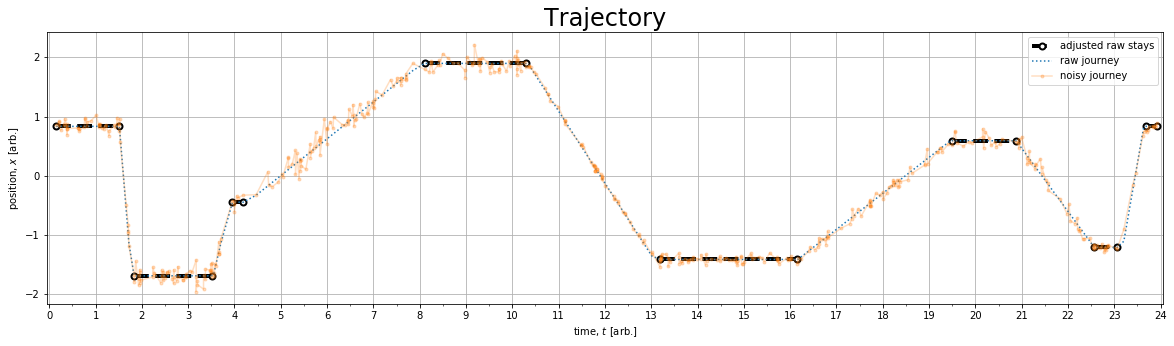

In [55]:
plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh'])

## Save the trajectory

### Pickling

In [11]:
from synthetic_data.trajectory_class import pickle_trajectory
from datetime import datetime

In [12]:
stays_tag = int((x_segs.size)/3)
date_tag = datetime.today().strftime('%Y%m%d')
notes = ''
trajectory_tag = f"{date_tag}_trajectory_{stays_tag}stays__{notes}"
path_to_file =  "./testdata/" + trajectory_tag + ".pkl"
print(path_to_file)

./testdata/20200703_trajectory_5stays__.pkl


In [13]:
pickle_trajectory(time_arr, raw_arr, noise_arr, segments, None)

TypeError: expected str, bytes or os.PathLike object, not NoneType

### tabling

In [14]:
from synthetic_data.trajectory import get_stay_indices

In [30]:
true_indices = get_stay_indices(get_adjusted_stays(segments, time_arr), time_arr)
true_labels = np.zeros(time_arr.shape)

for pair in true_indices:
    true_labels[pair[0]:pair[1]+1] = 1

In [16]:
import pandas as pd

In [56]:
df = pd.DataFrame({'ID':time_arr.size*["#111111"], 'time':time_arr, 'x':raw_arr, 'nx':noise_arr, 'stay':np.array(true_labels).astype(bool)})

In [42]:
df.head(10)

,ID,time,x,nx,stay
0,#111111,0.053056,-0.407513,-0.414037,True
1,#111111,0.185278,-0.407513,-0.332827,True
2,#111111,0.289722,-0.407513,-0.447598,True
3,#111111,0.378889,-0.407513,-0.331953,True
4,#111111,0.428611,-0.407513,-0.350395,True
5,#111111,0.481111,-0.407513,-0.442189,True
6,#111111,0.551944,-0.407513,-0.357406,True
7,#111111,0.626389,-0.407513,-0.407316,True
8,#111111,0.626389,-0.407513,-0.386647,True
9,#111111,0.723611,-0.407513,-0.501745,True


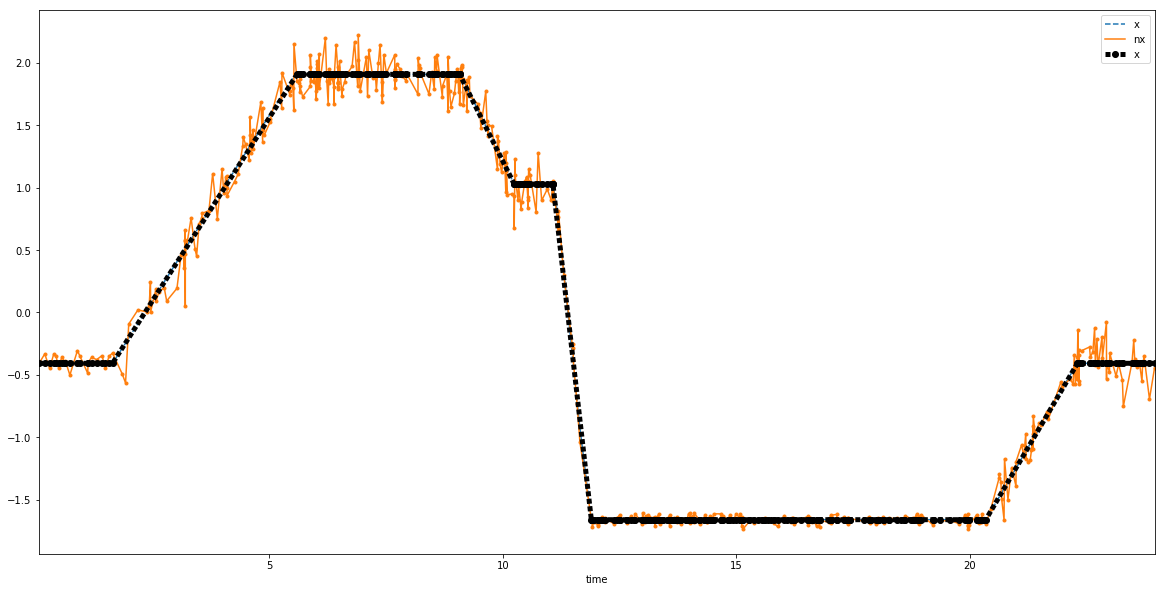

In [41]:
fig, ax = plt.subplots(figsize=[20,10])
df.plot(x='time', y='x', marker='', linestyle='--', ax=ax)
df.plot(x='time', y='nx', marker='.', linestyle='-', ax=ax)
df[df['stay']].plot(x='time', y='x', color='k',marker='o', linestyle='--', dashes=[1,0.5], linewidth=5, ax=ax)

In [ ]:
path_to_file =  "./testdata/" + trajectory_tag + ".csv"
df.to_csv(path_to_filez, index=False)

In [69]:
df.head()

,ID,time,x,nx,stay,time_bin
0,#111111,0.057778,1.597144,1.480571,True,0.057755
1,#111111,0.190000,1.597144,1.499828,True,0.189931
2,#111111,0.292222,1.597144,1.555307,True,0.292130
3,#111111,0.447778,1.597144,1.560354,True,0.447685
4,#111111,0.459167,1.597144,1.420859,True,0.459144


In [68]:
df2.head()

,ID,time,x,nx,stay,time_bin
0,#111111,0.151389,0.835056,0.855547,True,0.151273
1,#111111,0.210278,0.835056,0.903213,True,0.210185
2,#111111,0.215556,0.835056,0.920823,True,0.215509
3,#111111,0.215556,0.835056,0.857793,True,0.215509
4,#111111,0.250000,0.835056,0.768361,True,0.249884


In [88]:
binw = 1/(24)

df['time_bin'] = df['time'].apply(lambda x: x-x%binw)
df2['time_bin'] = df2['time'].apply(lambda x: x-x%binw)


In [91]:
dfm = df[['time_bin', 'nx']].merge(df2[['time_bin', 'nx']], on='time_bin', how='inner').head()

In [92]:
dfm.shape

(5, 3)

In [50]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

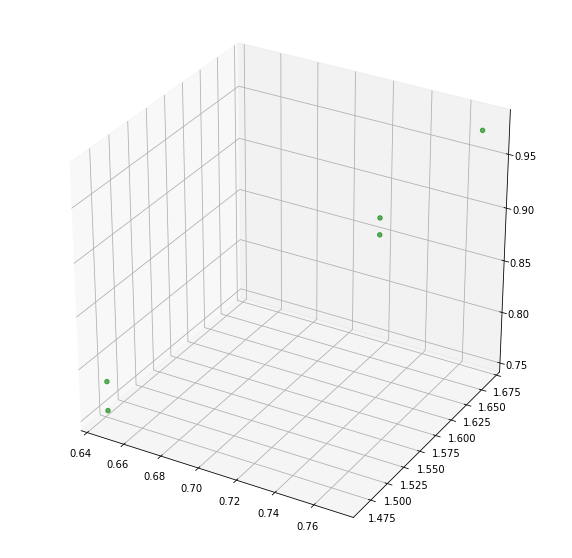

In [84]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')

'''
ax.errorbar(range(4), meanM0, yerr=stddevM0, color='g', linestyle='-.',  linewidth=3, alpha=0.99) 
ax.errorbar(range(4), meanM1, yerr=stddevM1, color='r', linestyle='--', linewidth=3, alpha=0.99) 
ax.errorbar(range(4), meanM2, yerr=stddevM2, color='b', linestyle=':',  linewidth=3, alpha=0.99) 

ax.legend(['0','1','2'])
'''
ax.scatter(dfm.time_bin, dfm.nx_x, dfm.nx_y, color='g', alpha=0.61, label=None)  
  
#    ax.scatter(xs, ys, zs, marker=m)

#ax.set_xlabel('X Label: '+dataset.feature_names[0])
#ax.set_ylabel('Y Label: '+dataset.feature_names[2])
#ax.set_zlabel('Z Label: '+dataset.feature_names[3])

plt.show();

In [104]:
binw = 1/12

df['time_bin'] = df['time'].apply(lambda x: x-x%binw)
df2['time_bin'] = df2['time'].apply(lambda x: x-x%binw)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

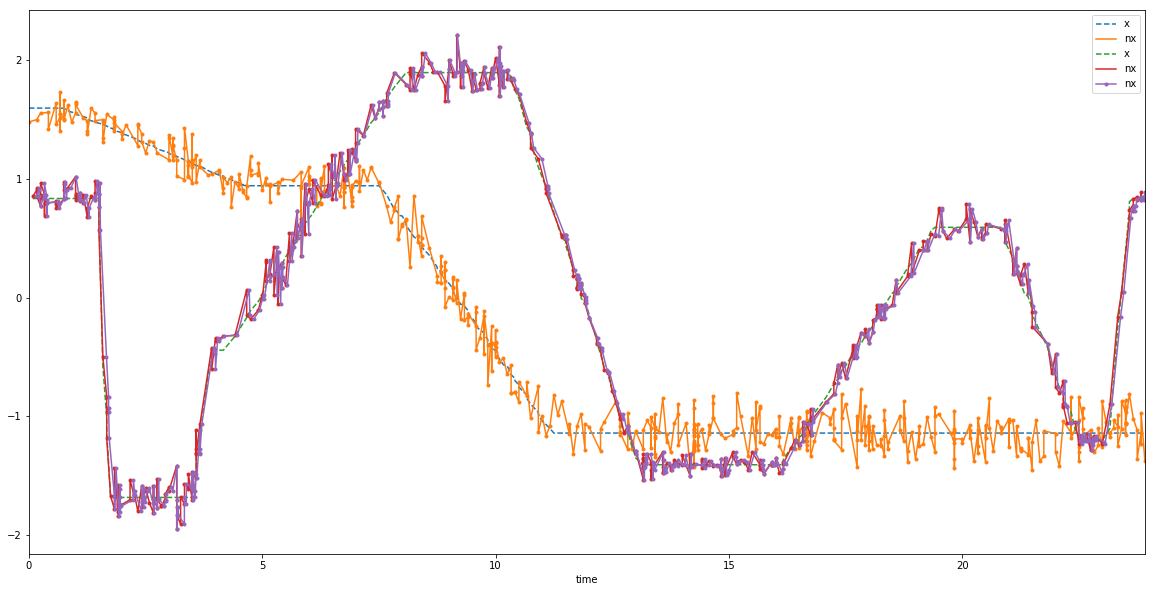

In [105]:
fig, ax = plt.subplots(figsize=[20,10])
df.plot(x='time_bin', y='x', marker='', linestyle='--', ax=ax)
df.plot(x='time_bin', y='nx', marker='.', linestyle='-', ax=ax)
df2.plot(x='time_bin', y='x', marker='', linestyle='--', ax=ax)
df2.plot(x='time_bin', y='nx', marker='.', linestyle='-', ax=ax)
df2.plot(x='time', y='nx', marker='.', linestyle='-', ax=ax)


In [97]:
df.head(10)

,ID,time,x,nx,stay,time_bin
0,#111111,0.057778,1.597144,1.480571,True,0.041667
1,#111111,0.190000,1.597144,1.499828,True,0.166667
2,#111111,0.292222,1.597144,1.555307,True,0.291667
3,#111111,0.447778,1.597144,1.560354,True,0.416667
4,#111111,0.459167,1.597144,1.420859,True,0.458333
5,#111111,0.613611,1.597144,1.639253,True,0.583333
6,#111111,0.662778,1.597144,1.464061,True,0.625000
7,#111111,0.683056,1.597144,1.513671,True,0.666667
8,#111111,0.697500,1.597144,1.404687,True,0.666667
9,#111111,0.700833,1.597144,1.543279,True,0.666667


In [98]:
df2.plot(x='time_bin', y='nx', marker='.', linestyle='-', ax=ax)